### Installing and Importing Libraries

In [2]:
# pip install mediapipe rembg onnxruntime

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from rembg import remove
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

C:\Users\Shivam 007\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [4]:
img = ("C:\\Users\\Shivam 007\\Downloads\\Silhouette\\images.jpeg")

### Removing Background

In [6]:
def remove_background(image_path):
    """
    Removes the background from the input image using rembg and sets the background to black.

    Args:
        image_path (str): Path to the input image.

    Returns:
        np.ndarray: The image with the background removed and set to black.
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    # Convert the image to RGB for rembg processing
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Use rembg to remove the background
    input_image = Image.fromarray(image_rgb)
    output_image = remove(input_image)
    bg_removed = np.array(output_image)

    # Set background to black (replace transparency with black)
    if bg_removed.shape[-1] == 4:  # Check if alpha channel exists
        alpha_channel = bg_removed[:, :, 3]
        bg_removed = cv2.cvtColor(bg_removed, cv2.COLOR_BGRA2BGR)
        black_background = np.zeros_like(bg_removed)
        bg_removed = np.where(alpha_channel[:, :, None] > 0, bg_removed, black_background)

    return bg_removed

In [7]:
def find_and_filter_roi(image):
    """
    Automatically finds the largest contour (ROI) in the image and filters out unnecessary parts.

    Args:
        image (np.ndarray): The input image with the background removed.

    Returns:
        np.ndarray: The filtered image with only the main ROI retained.
    """
    # Convert to grayscale
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create a binary mask
    _, binary = cv2.threshold(grayscale, 1, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)

    # Create a mask for the largest contour
    mask = np.zeros_like(binary)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)

    # Apply the mask to the image
    filtered_image = cv2.bitwise_and(image, image, mask=mask)

    # Turn the rest of the image black
    black_background = np.zeros_like(image)
    result_image = np.where(mask[:, :, None] == 255, filtered_image, black_background)

    return result_image

In [8]:
bg_removed = remove_background(img)
filtered_image = find_and_filter_roi(bg_removed)

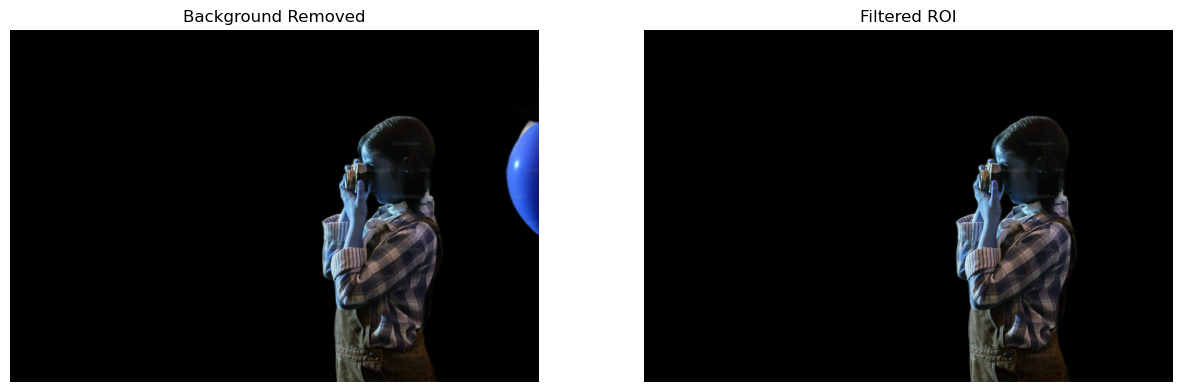

In [9]:
# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Background Removed")
plt.imshow(cv2.cvtColor(bg_removed, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Filtered ROI")
plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

### Creating Silhouette

In [11]:
def create_silhouette(image, output_path="silhouette.png"):
    """
    Creates a silhouette from the input filtered image.

    Args:
        image (np.ndarray): The filtered image with only the main ROI retained.
        output_path (str): Path to save the silhouette image.

    Returns:
        np.ndarray: The silhouette image.
    """
    # Convert to grayscale and create a binary mask for the silhouette
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(grayscale, 1, 255, cv2.THRESH_BINARY)

    # Invert the binary mask to create the silhouette
    silhouette = cv2.bitwise_not(binary_mask)

    # Save the silhouette
    cv2.imwrite(output_path, silhouette)

    return silhouette

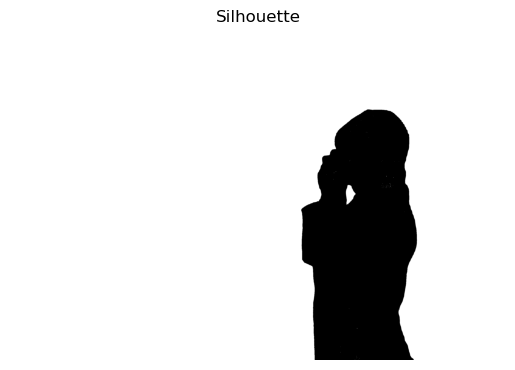

In [12]:
silhouette = create_silhouette(filtered_image, "silhouette_output.png")

plt.title("Silhouette")
plt.imshow(silhouette, cmap='gray')
plt.axis('off')

plt.show()